In [1]:
import numpy as np
import freegs
from freegs.plotting import plotConstraints
from freegs.critical import find_critical
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sys
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

In [2]:
# %matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Create the machine, which specifies coil locations
# and equilibrium, specifying the domain to solve over
# this has to be either
# freegs.machine.MASTU(), in which case:
#tokamak = freegs.machine.MASTU()
# or
# MASTU_coils.MASTU_wpass()
from freegsnke import MASTU_coils
tokamak = MASTU_coils.MASTU_wpass()


# Creates equilibrium object and initializes it with 
# a "good" solution
# plasma_psi = np.loadtxt('plasma_psi_example.txt')
eq = freegs.Equilibrium(tokamak=tokamak,
                        #domains can be changed 
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-2.2, Zmax=2.2,   # Height range
                        #grid resolution can be changed
                        nx=65, ny=129, # Number of grid points
                        # psi=plasma_psi[::2,:])   
                        )  

# Sets desired plasma properties for the 'starting equilibrium'
# values can be changed
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(8.1e3, # Plasma pressure on axis [Pascals]
                            6.2e5, # Plasma current [Amps]
                            0.5, # vacuum f = R*Bt
                            alpha_m = 1.8,
                            alpha_n = 1.2)


# Sets some shape constraints (here very close to those used for initialization)
Rx = 0.6
Zx = 1.1

Rmid = 1.4   # Outboard midplane
Rin = 0.4  # Inboard midplane

xpoints = [(Rx, -Zx-.01),   # (R,Z) locations of X-points
           (Rx,  Zx)]
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
    
           # Link inner and outer midplane locations
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),

           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False

constrain = freegs.control.constrain(xpoints=xpoints, 
                                     gamma=5e-6, 
                                     isoflux=isoflux
                                    )
constrain(eq)
                                    
from freegsnke import newtonkrylov
NK = newtonkrylov.NewtonKrylov(eq)

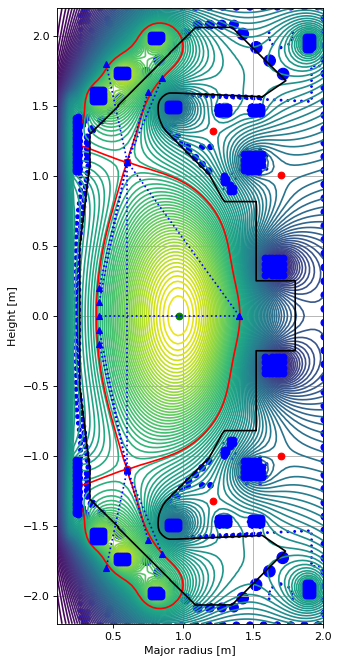

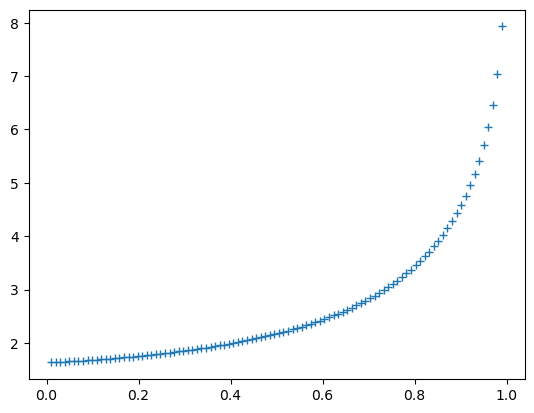

In [6]:
eq.tokamak['P6'].current = 0
eq.tokamak['P6'].control = False
eq.tokamak['Solenoid'].control = False
eq.tokamak['Solenoid'].current = 15000
# Nonlinear solve
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)               
eq.tokamak['Solenoid'].current = 40000
freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The plasma profiles
             constrain,   # Plasma control constraints
             show=False,
             rtol=3e-3)  
NK.solve(eq, profiles, rel_convergence=1e-8)
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);
constrain.plot(axis=ax,show=False)

qprof = eq.q()
plt.figure()
plt.plot(qprof[0], qprof[1], '+')
plt.title('q profile')

In [7]:
# Initialize the evolution object
# This uses the starting equilibrium to get all the geometric constraints/grids etc
from freegsnke import nonlinear_solve
stepping = nonlinear_solve.nl_solver(profiles=profiles, eq=eq, 
                                        max_mode_frequency=10**2.5, 
                                        full_timestep=1e-4, 
                                   #      max_internal_timestep=5e-3,
                                        extrapolator_input_size=16,
                                        extrapolator_order=1,
                                        plasma_norm_factor=500,
                                        plasma_resistivity=1e-6)
# this is the number of independent vessel normal modes (maximum is 699)
print('Input max_mode_frequency corresponds to ', 
       stepping.n_metal_modes, ' independent vessel normal modes')

# In absence of a policy, this calculates the active voltages U_active
# to maintain the currents needed for the equilibrium statically
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils]

Input max_mode_frequency corresponds to  136  independent vessel normal modes


'Step: 199/199'

'current time t = 0.019899999999999935'

'current time step dt = 0.0001'

Text(0, 0.5, 'Plasma elongation')

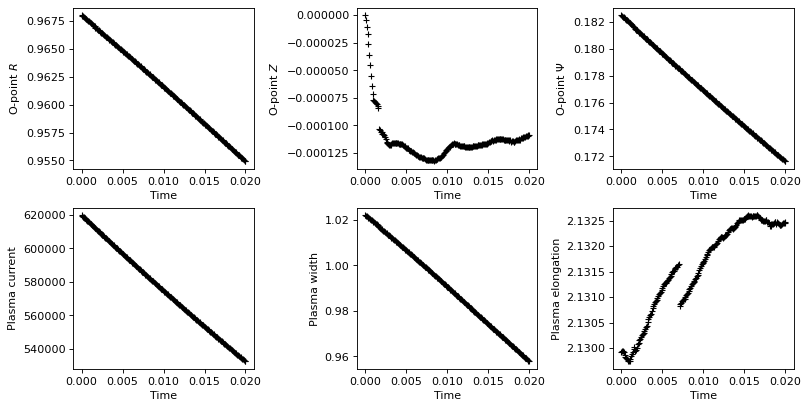

In [8]:
# Example of evolution with constant applied voltages
t = 0
flag = 0
history_times = [t]
t_per_step = []

#use the following to reset stepping.eq1 to a new IC
stepping.initialize_from_ICs(eq, profiles)

history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = stepping.shapes(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]
history_dJs = [stepping.dJ]

counter = 0
max_count = 200
while flag<1 and counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    display(f'current time step dt = {stepping.dt_step}')
    
    t_start = time.time()
    flag = stepping.nl_step_iterative_dJ( active_voltage_vec=U_active, 
                                            dJ=stepping.dJ,
                                            alpha=.73, 
                                            rtol_NK=1e-6,
                                            atol_currents=1e-8,
                                            atol_J=1e-8,
                                            verbose=False)
   
    t_end = time.time()
    t_per_step.append(t_end-t_start)

    t += stepping.dt_step
    history_times.append(t)
    shapes = stepping.shapes(stepping.eq2, stepping.profiles2)

    history_currents.append(stepping.currents_vec)
    history_equilibria.append(deepcopy(stepping.eq2))
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])
    history_dJs.append(stepping.dJ)
    counter += 1

history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)


# Evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')

axs_flat[1].plot(history_times, history_o_points[:, 1],'k+')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('O-point $Z$')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')